some basic analysis of the smiles.

In [2]:
import pandas as pd
from collections import defaultdict

from tqdm.notebook import tqdm

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdMolDescriptors, Descriptors

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm.contrib.concurrent import process_map

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def getLogP(x): return Chem.rdMolDescriptors.CalcCrippenDescriptors(x)[0]
def getMW(x): return Chem.Descriptors.MolWt(x)
def getHBD(x): return Chem.rdMolDescriptors.CalcNumHBD(x)
def getHBA(x): return Chem.rdMolDescriptors.CalcNumHBA(x)
def getPSA(x): return Chem.rdMolDescriptors.CalcTPSA(x)
def getROTB(x): return Chem.rdMolDescriptors.CalcNumRotatableBonds(x)
def getAROM(x): return Chem.rdMolDescriptors.CalcNumAromaticRings(x)
def getFSP3(x): return Chem.rdMolDescriptors.CalcFractionCSP3(x)
def getFC(x): return Chem.rdmolops.GetFormalCharge(x)
def getQED(x): return Chem.QED.qed(x)
def getSSSR(x): return Chem.GetSSSR(x)

def getallprops(s):
    x = Chem.MolFromSmiles(s)
    return [getLogP(x),getMW(x),getHBD(x),getHBA(x),getPSA(x),getROTB(x),getFSP3(x),getSSSR(x),getQED(x)]

In [5]:
def interpolate_data_df(df):
    """takes a dataframe of values and does interpolation"""
    
    prop_dict = {}
    minmax_dict = {}
    
    for p in list(df):
        minv = np.min(df[p])
        maxv = np.max(df[p])
        minmax_dict[p] = (minv,maxv)
        prop_dict[p] = np.interp(df[p],(minv,maxv),(0,1))
        
    df_out = pd.DataFrame(data=prop_dict)    
    return df_out, minmax_dict


# a new helper function
def interp_point(data_point,minmax_dict):
    dict_out = {}
    for i,k in enumerate(minmax_dict.keys()):
        minv,maxv = minmax_dict[k]
        dict_out[k] = np.interp(data_point[i],(minv,maxv),(0,1))
        
    return dict_out


In [6]:
data = pd.read_csv("./data_files/acid_amine_smiles_mindist_dbank.csv",index_col=0)
data.sort_values("drugbank_matches",inplace=True,ascending=False)

In [7]:
all_elems = []
for r in data.itertuples():
    s = r.smiles
    elems = "C"
    if "N" in s or "n" in s:
        elems += "N"
        
    if "O" in s or "o" in s:
        elems += "O"
    all_elems.append(elems)

In [8]:
data["elems"] = all_elems

data_plot = data[:100].copy()

data_plot.head()

,smiles,min_dist_all,natoms,drugbank_matches,elems
9739,CCCC,3.0,4,6806,C
694,CCNC,2.0,4,5632,CN
1384,CCCN,2.0,4,5568,CN
1313,CCCO,2.0,4,5379,CO
83270,CCCCC,5.0,5,5314,C


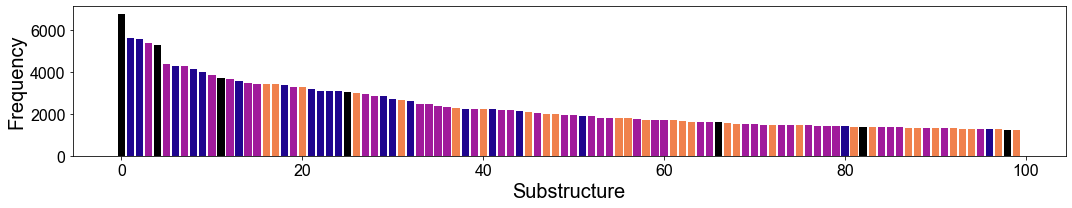

In [10]:
x_plt = np.arange(len(data_plot))
y_plt = np.array(data_plot.drugbank_matches)

mask_c = np.array(data_plot.elems == "C")
mask_n = np.array(data_plot.elems == "CN")
mask_o = np.array(data_plot.elems == "CO")
mask_no = np.array(data_plot.elems == "CNO")

# k = 4
# legends_temp = [str(i) for i in list(data1.drugbank_matches[k*50:(k+1)*50])]
# Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in data1.smiles[k*50:(k+1)*50]],molsPerRow=5,legends=legends_temp)


plt.figure(figsize=(15,3))
plt.bar(x_plt[mask_o], y_plt[mask_o], color = (160/255,27/255,155/255,1))
plt.bar(x_plt[mask_n], y_plt[mask_n], color = (31/255,5/255,142/255,1))
plt.bar(x_plt[mask_c], y_plt[mask_c], color = 'black')
plt.bar(x_plt[mask_no], y_plt[mask_no], color = (240/255,129/255,77/255,1))

ax = plt.gca()

x_labs = [0,20,40,60,80,100]
y_labs = [0,2000,4000,6000]
ax.set_xticks(x_labs)
ax.set_yticks(y_labs)
ax.set_xticklabels(x_labs, fontsize=16, fontfamily="arial")
ax.set_yticklabels(y_labs, fontsize=16, fontfamily="arial")


plt.xlabel("Substructure",font="Arial",fontsize=20)
plt.ylabel("Frequency",font="Arial",fontsize=20)
# plt.title("Top 100 most frequent DrugBank matches",fontsize=50,font="Arial")
plt.tight_layout()
plt.savefig("fig6_bar.png",dpi=900)
plt.show()

In [11]:
getallprops("CCC")

[1.4163, 44.096999999999994, 0, 0, 0.0, 0, 1.0, 0, 0.3854706587740357]

In [ ]:
all_molprops = process_map(getallprops,list(data.smiles),max_workers=32,chunksize=100)

data["allprops"] = all_molprops
data[["LogP","MW","HBD","HBA","PSA","ROTB","FSP3","SSSR","QED"]] = data.allprops.tolist()

data.drop("allprops",axis=1,inplace=True)
all_molprops = []

In [ ]:
data.to_csv("./data_files/acid_amine_props.csv",index=False)

In [8]:

data= pd.read_csv("./data_files/acid_amine_props.csv")

In [12]:
amide_props = np.array(getallprops("CCC(NCC)=O"))

In [13]:
props_interp, minmax_dict =  interpolate_data_df(data[list(data)[5:]])

# interpolated difference for *plotting location*
amide_interp = interp_point(amide_props,minmax_dict)



In [14]:
props_interp = props_interp[['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'ROTB', 'SSSR']].copy()

props_interp.rename(columns={"SSSR":"Rings"},inplace=True)

df_plot = props_interp.melt(var_name = "property")



In [15]:

amide_interp["Rings"] = 0
amide_props_raw = np.array(getallprops("CCC(NCC)=O"))

minmax_dict["Rings"] = (0,13)



In [ ]:
 np.interp(df[p],(minv,maxv),(0,1))

In [22]:
np.interp([1,2,3],(1,3),(0,1))

array([0. , 0.5, 1. ])

In [24]:
x_locs_vals = np.array([
    
    [-3.2, 0.53, 2.2],
[48.04, 101.15, 119.16],
[0, 1.0, 3],
[0, 1.0, 3],
[0.0, 29.1, 66.48],
[0, 2.0, 5],
[0.0, 0.8, 1.0],
[0, 0.0, 13],
[0.1, 0.54, 0.65]
])


x_locs_text =np.array([
    
    [-3.2, 0.53, 2.2],
[48.04, 101.15, 119.16],
[0, 1.0, 3],
[0, 1.0, 3],
[0.0, 29.1, 66.48],
[0, 2.0, 5],
[0.0, 0.8, 1.0],
[0, 0.0, 13],
[0.1, 0.54, 0.65]
])

x_locs_interp = [np.interp(i,(min(i),max(i)),(0,1)) for i in x_locs_vals]

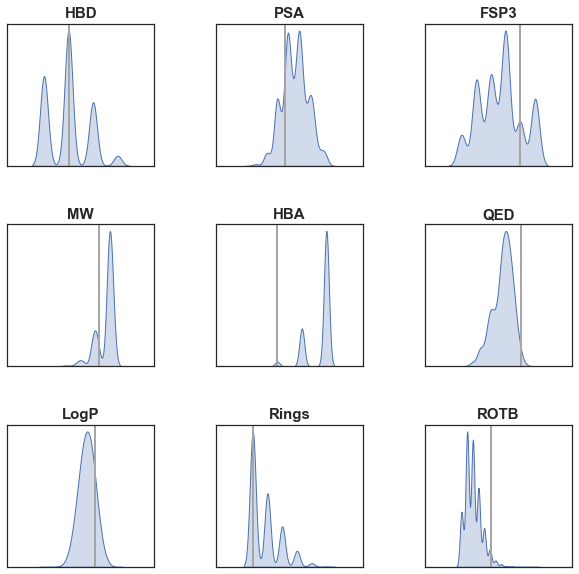

In [33]:
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.2)
g = sns.FacetGrid(df_plot,col = "property",
                  aspect=1,height=1.16798*2.5,col_wrap=3,
                  sharex=False,sharey=False,palette="plasma")

g.map(sns.kdeplot, "value",clip_on=True,shade=True,bw_method=0.2);
g.set(yticks=[])

g.despine(top=False, right=False)
titles = ['HBD', 'PSA', 'FSP3', 'MW', 'HBA', 'QED', 'LogP', 'Rings', "ROTB"]

for i, ax in enumerate(g.axes.flat): # set every-other axis for testing purposes
    title = titles[i]
    
    ax.set_title(title, fontweight='bold',fontsize=15)
    M_loc = amide_interp[title]
    ax.set_ylabel("")
    ax.set_xticks([])
    # removed for publishing purposes
#     ax.set_xticks(x_locs_interp[i])
#     ax.set_xticklabels(x_locs_text[i],rotation=45)
    ax.set_xlim(-.5,1.5)
    
    
    greys = 0.65
    ax.axvline(amide_interp[title], color=(greys,greys,greys), linewidth=2)

g.set_xlabels("")
# plt.tight_layout()
plt.subplots_adjust(hspace=0.41)

# g.fig.suptitle(r"Molecular Properties",fontweight='bold',fontsize=16)
plt.savefig(f"./figures/fig3_KDEs.png",dpi=900)

In [12]:
def cal_pmi(s):
    try:
        m = Chem.MolFromSmiles(s)
        Chem.SanitizeMol(m)
        mol = Chem.AddHs(m)
        AllChem.EmbedMolecule(mol)
        x = Chem.Descriptors3D.NPR1(mol)
        y = Chem.Descriptors3D.NPR2(mol)
        return x, y
    except:
        return None,None

In [1]:
pmi = process_map(cal_pmi,list(data.smiles),max_workers=24,chunksize=1000)

In [17]:
data["pmi"] = pmi
data[["pmi_x","pmi_y"]] = data.pmi.tolist()
data.drop("pmi",axis=1,inplace=True)

In [20]:
data_for2d = data[np.isfinite(data.pmi_x)].copy()

data_for2d.head()

# data_in_db = data_for2d[data_for2d.drugbank_matches>0]

,smiles,min_dist_all,natoms,drugbank_matches,in_320,LogP,MW,HBD,HBA,PSA,ROTB,FSP3,SSSR,QED,pmi_x,pmi_y
0,COON,6.0,4,0,False,-0.5619,63.056,1,3,44.48,1,1.0,0,0.327421,0.231173,0.930233
1,CONO,6.0,4,18,False,-0.4734,63.056,2,3,41.49,1,1.0,0,0.403979,0.218395,0.946052
2,CON=O,7.0,4,19,False,0.3142,61.040,0,3,38.66,1,1.0,0,0.323100,0.133342,0.945516
3,NOCO,4.0,4,4,False,-1.1735,63.056,2,3,55.48,1,1.0,0,0.297497,0.279527,0.833241
4,C1ONO1,5.0,4,0,False,-0.5897,61.040,1,3,30.49,0,1.0,1,0.405801,0.517361,0.565741


In [32]:
amide_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in "CCC(NCC)=O.C=CC(NCC)=O.C=CC(NC=C)=O.CCC(NC=C)=O".split(".")]

amide_data = data_for2d[data_for2d.smiles.isin(amide_smiles)]


In [ ]:
data_for2d[["smiles","pmi_x","pmi_y"]].to_csv("./data_files/acid_amine_pmi.csv")

[]

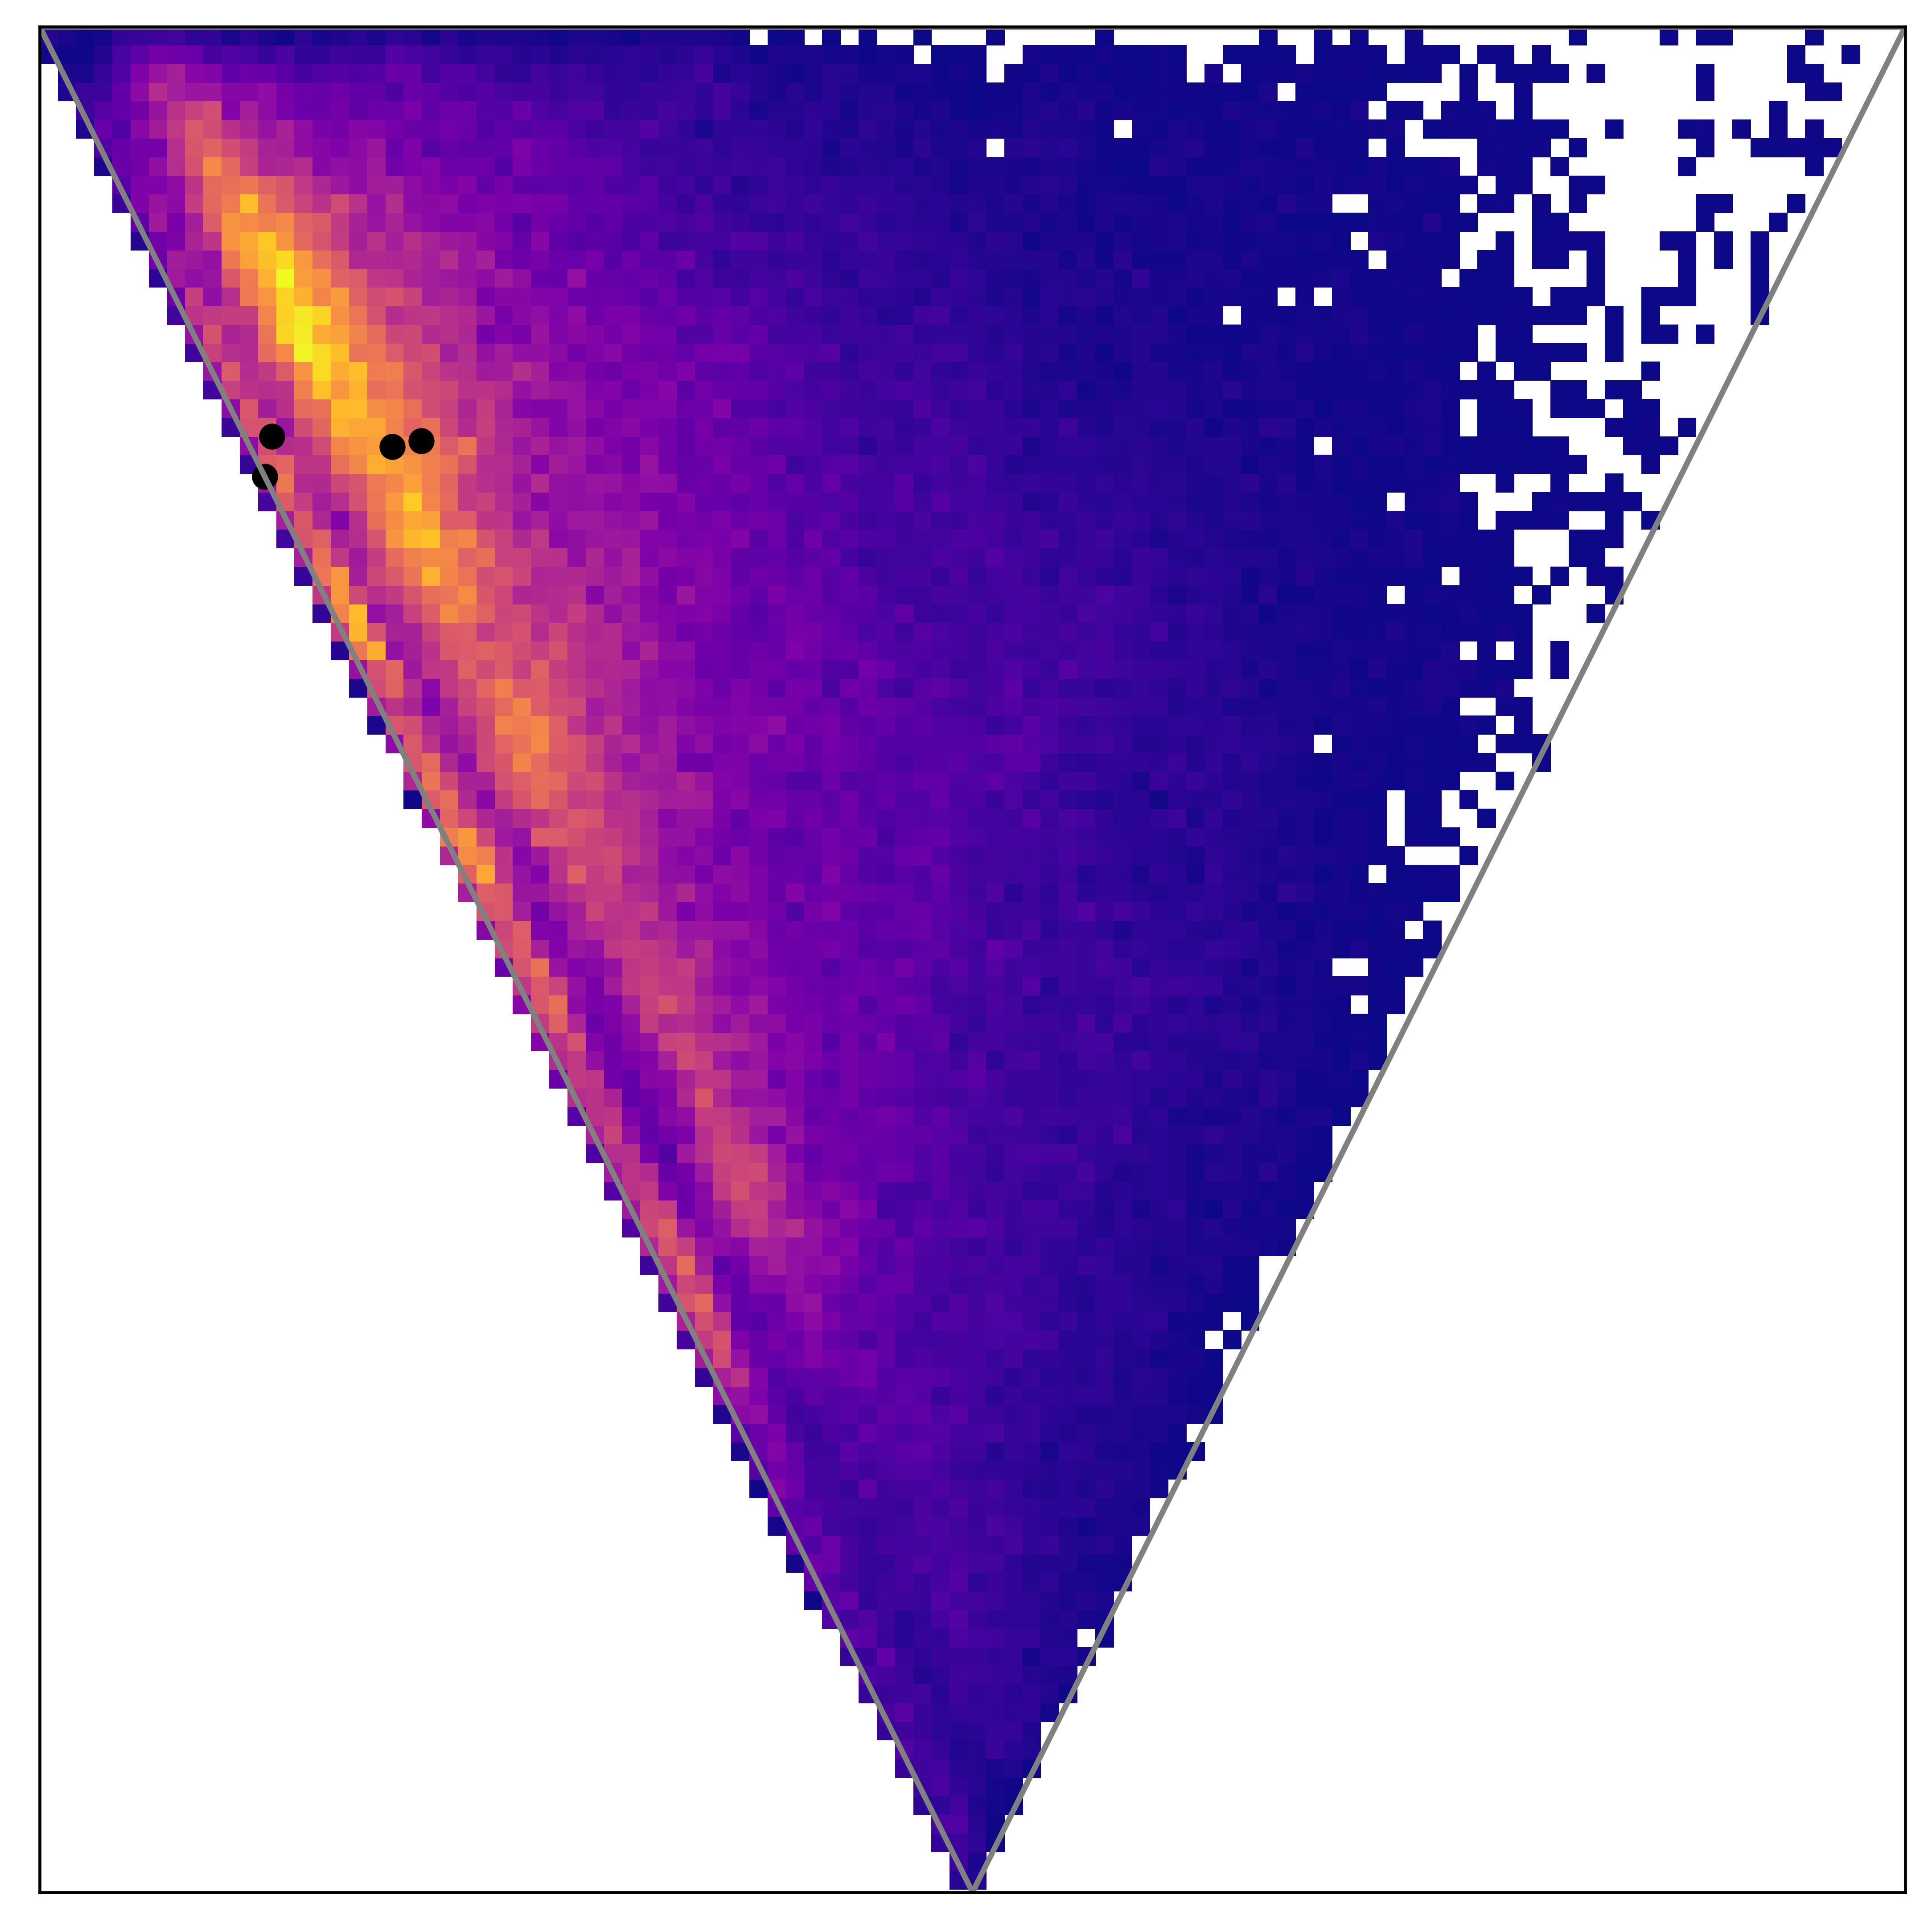

In [33]:
# import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,18),dpi=600)

h = ax.hist2d(list(data_for2d.pmi_x), list(data_for2d.pmi_y),bins=100,cmin=1,cmap="plasma")


ax.set_xlim((0,1))
ax.set_ylim((0.5,1))
ax.plot([0,.5], [1,0.5],color='gray')
ax.plot([.5,1], [0.5,1],color='gray')
ax.plot([0,1], [1,1],color='gray')
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
divider = make_axes_locatable(ax)


# # the 4 amides 
ax.scatter(amide_data.pmi_x,amide_data.pmi_y,color="k")
ax.set_xticks([])
ax.set_yticks([])

# fig.savefig('pmi_all200k_density_900.png', dpi=900)
# plt.close(fig)